In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "aa1_perfect_1.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superking/
Found 27 parquet files in datasets/superking/
Loading superking dataset...


In [4]:
superking_df = superking_df.drop(columns=["reasoning"])

In [5]:

from llm_python.datasets.query import filter_soar_df

df = superking_df.copy()
df = filter_soar_df(
    df,
    exclude_subset="arc-prize-2024/training",
    all_train_correct=True,
    all_test_correct=True,
)


In [6]:
# Deduplicate df by task_id and code, preferring rows with refined_from_id notna
initial_len = len(df)
df = (
    df.sort_values(by="refined_from_id", na_position="last")  # refined rows first
      .drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 42861 (removed 25433)


In [7]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "code_length"],
    sort_ascending=[False, False, True],
    task_limit=2,
)

In [8]:
print(len(df))
print(df.head())

724
                                 row_id   task_id  \
15989  e9fe5ae2b282a39dcbc64a22eb156e9b  3cd86f4f   
16007  8ae3a2a2f0e1e1a9a2bfc25b2c3d88ba  3cd86f4f   
838    d921dd021ff1293d1b6f16647b801ec2  af726779   
12025  7f72da96dbcd6714255dfc540958fde2  af726779   
5247   c93ac08618ec783a259e8dab5ca19132  bbb1b8b6   

                                                    code  \
15989  def transform(grid):
    n = len(grid)
    m =...   
16007  def transform(grid):
    n = len(grid)
    out...   
838    def transform(grid):

    out = [row[:] for ro...   
12025  def transform(grid):

    out = [row[:] for ro...   
5247   def transform(grid):

    left = [row[:4] for ...   

                               correct_train_input   correct_test_input  \
15989                          [ True  True  True]  [ True  True  True]   
16007                          [ True  True  True]  [ True  True  True]   
838                            [ True  True  True]  [ True  True  True]   
12025           

In [9]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=PARQUET_SCHEMA)

Saving final dataset to: /home/lewis/code/trelis-arc/aa1_perfect_1.parquet


DATASET STATISTICS ANALYSIS: aa1_perfect_2
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 377
   • Total programs: 724
   • Fully correct programs: 724 (100.0%)
   • Partially correct programs: 0 (0.0%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 1.000

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 1.9
   • Median programs per task: 2.0
   • Min programs per task: 1
   • Max programs per task: 2
   • Tasks with 2 programs (max): 347
   • Tasks with fully correct programs: 377
   • Tasks with no correct programs: 0

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 2.0
   • 50th percentile (median): 2.0
   • 75th percentile: 2.0
   • 90th percentile: 2.0
   • 95th percentile: 2.0
   • 99th percentile: 2.0
   • 100th percentile (max): 2.0

4. Creating visualizations...


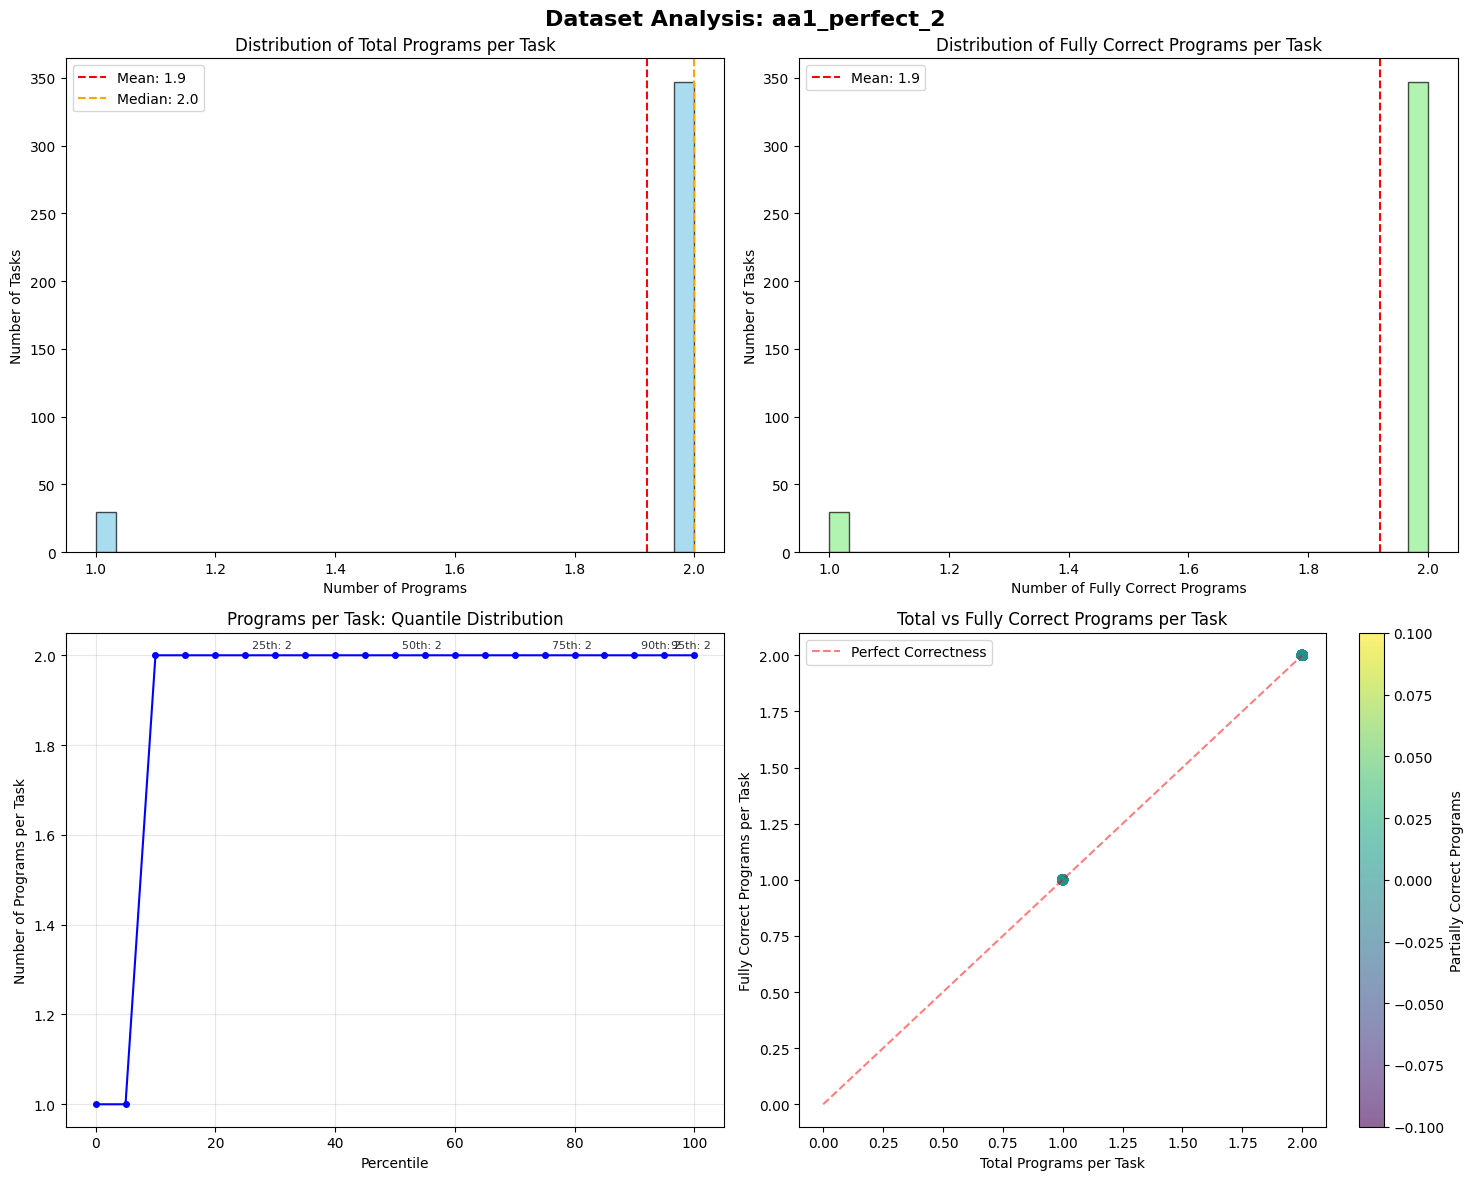


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [10]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, "aa1_perfect_2")